# 🧠 PyTorch Neural Network Training
====================================

Step-by-step exploration of the `pytorch_network.py` implementation for robot navigation.

**What you'll learn:**
- PyTorch neural network architecture and training
- Configuration management with YAML
- Model evaluation and performance analysis


## 1. Setup and Data Loading


In [9]:
# Setup and imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import our custom modules
from core.pytorch_network import RobotNavigationNet, RobotNavigationTrainer, load_config, create_data_loaders
from core.data_generation import load_training_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"🖥️  PyTorch version: {torch.__version__}")
print(f"🔧 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Load configuration and data
config = load_config()
data_path = project_root / "data" / "raw" / "large_training_dataset.npz"

try:
    X, y, metadata = load_training_data(data_path)
    print(f"\n✅ Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"📊 Action distribution: {np.bincount(y)}")
except FileNotFoundError:
    print(f"❌ Data file not found: {data_path}")
    print("💡 Run 'python scripts/generate_data.py small' first")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X, y,
    batch_size=config['training']['batch_size'],
    train_ratio=config['data']['train_ratio'],
    val_ratio=config['data']['val_ratio'],
    test_ratio=config['data']['test_ratio']
)

print(f"📊 Data splits: Train={len(train_loader.dataset)}, Val={len(val_loader.dataset)}, Test={len(test_loader.dataset)}")


✅ Setup complete!
🖥️  PyTorch version: 2.8.0
🔧 Device: CPU
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
📂 Training data loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/data/raw/large_training_dataset.npz

✅ Data loaded: 8619 samples, 9 features
📊 Action distribution: [2202 2136 2160 2121]
📊 Data splits:
   Train: 6895 samples
   Validation: 862 samples
   Test: 862 samples
📊 Data splits: Train=6895, Val=862, Test=862


## 2. Model Architecture


In [12]:
# Create model
model = RobotNavigationNet(
    input_size=config['model']['input_size'],
    hidden1_size=config['model']['hidden1_size'],
    hidden2_size=config['model']['hidden2_size'],
    output_size=config['model']['output_size'],
    dropout_rate=config['model']['dropout_rate']
)

# Get architecture info
info = model.get_architecture_info()
print("🧠 Neural Network Architecture:")
print(f"   Architecture: {info['architecture']}")
print(f"   Total parameters: {info['total_parameters']:,}")
print(f"   Trainable parameters: {info['trainable_parameters']:,}")
print(f"   Dropout rate: {info['dropout_rate']}")

# Show model structure
print("\n🔍 Model Structure:")
print(model)


🧠 Neural Network Architecture:
   Architecture: 9 → 64 → 32 → 4
   Total parameters: 2,852
   Trainable parameters: 2,852
   Dropout rate: 0.1

🔍 Model Structure:
RobotNavigationNet(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


## 3. Training


In [13]:
# Create trainer
trainer = RobotNavigationTrainer(
    model=model,
    learning_rate=config['training']['learning_rate']
)

print("✅ Model and trainer created!")
print(f"📊 Training configuration:")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Max epochs: {config['training']['epochs']}")
print(f"   Early stopping patience: {config['training']['early_stopping']['patience']}")

# Train the model
print(f"\n🏋️ Starting training...")
history = trainer.train(
    train_loader, val_loader,
    epochs=config['training']['epochs'],
    early_stopping_patience=config['training']['early_stopping']['patience']
)

print(f"\n✅ Training completed!")
print(f"📊 Final results:")
print(f"   Best validation accuracy: {max(history['val_accuracies']):.4f}")
print(f"   Best validation loss: {min(history['val_losses']):.4f}")
print(f"   Training epochs: {len(history['train_losses'])}")


✅ Model and trainer created!
📊 Training configuration:
   Learning rate: 0.0005
   Batch size: 32
   Max epochs: 100
   Early stopping patience: 55

🏋️ Starting training...
🚀 Starting training on cpu
🧠 Architecture: 9 → 64 → 32 → 4
⚙️  Learning rate: 0.0005
🛡️  Dropout rate: 0.1
------------------------------------------------------------
Epoch   0: Train Loss=1.3513, Train Acc=39.97%, Val Loss=1.3185, Val Acc=45.48%
Epoch  10: Train Loss=1.2528, Train Acc=45.82%, Val Loss=1.2572, Val Acc=43.27%
Epoch  20: Train Loss=1.2461, Train Acc=46.35%, Val Loss=1.2585, Val Acc=43.27%
Epoch  30: Train Loss=1.2454, Train Acc=46.18%, Val Loss=1.2571, Val Acc=43.04%
Epoch  40: Train Loss=1.2435, Train Acc=46.38%, Val Loss=1.2573, Val Acc=42.00%
Epoch  50: Train Loss=1.2414, Train Acc=46.40%, Val Loss=1.2552, Val Acc=42.81%
Epoch  60: Train Loss=1.2414, Train Acc=46.73%, Val Loss=1.2547, Val Acc=43.62%
Epoch  70: Train Loss=1.2392, Train Acc=46.61%, Val Loss=1.2553, Val Acc=43.74%
Epoch  80: Train Lo

## 4. Training Visualization


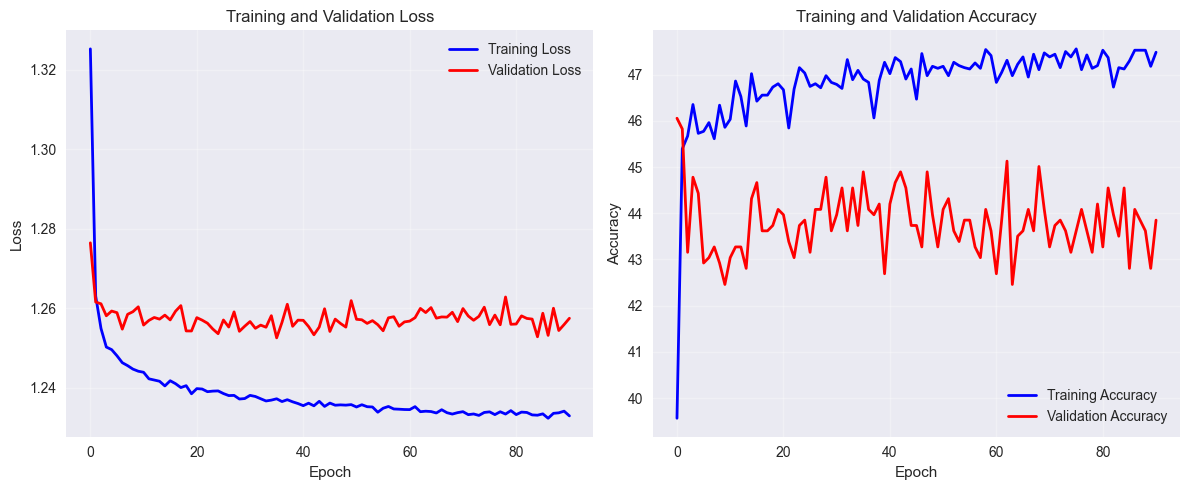


🔍 Training Analysis:
   Training Accuracy: 47.4837 (4748.4%)
   Validation Accuracy: 43.8515 (4385.2%)
   Overfitting: 3.6322 (363.2%)
⚠️  Warning: Significant overfitting detected!


In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze results
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n🔍 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting detected!")
elif overfitting < -0.05:
    print(f"✅ Good: Model is not overfitting")
else:
    print(f"✅ Acceptable: Minimal overfitting")


## 5. Model Evaluation


In [ ]:
# Evaluate on test set
test_accuracy, test_loss = trainer.evaluate(test_loader)
print(f"📊 Test Set Performance:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Test Loss: {test_loss:.4f}")

# Get predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=action_names, yticklabels=action_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.show()

# Print classification report
print(f"\n📋 Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=action_names))


## 7. Architecture Design Choices Explained

**Why 2 Hidden Layers with 64 → 32 neurons?**


In [ ]:
# Let's analyze the design choices with visualizations and examples

print("🧠 NEURAL NETWORK ARCHITECTURE DESIGN CHOICES")
print("=" * 60)

# 1. Why 2 Hidden Layers?
print("\n1️⃣ WHY 2 HIDDEN LAYERS?")
print("-" * 30)
print("• 1 Layer: Linear decision boundary (too simple)")
print("• 2 Layers: Can learn complex non-linear patterns ✅")
print("• 3+ Layers: Overkill for 9 inputs, risk of overfitting")
print("• Sweet spot: 2 layers for this problem complexity")

# 2. Why 64 → 32 neurons (decreasing pattern)?
print("\n2️⃣ WHY 64 → 32 NEURONS?")
print("-" * 30)
print("• Input: 9 features (3×3 perception)")
print("• Hidden1: 64 neurons (7× expansion for pattern extraction)")
print("• Hidden2: 32 neurons (3.5× compression for decision making)")
print("• Output: 4 neurons (4 actions)")
print("\n💡 The 'funnel' design:")
print("   - Extract patterns → Combine patterns → Make decisions")

# 3. Mathematical reasoning
print("\n3️⃣ MATHEMATICAL REASONING")
print("-" * 30)
input_size = 9
hidden1 = 64
hidden2 = 32
output_size = 4

total_params = (input_size * hidden1) + hidden1 + (hidden1 * hidden2) + hidden2 + (hidden2 * output_size) + output_size
print(f"• Total parameters: {total_params:,}")
print(f"• Training samples: {len(train_loader.dataset):,}")
print(f"• Parameters/Sample ratio: {total_params/len(train_loader.dataset):.1f}")
print("• Rule of thumb: <10 parameters per sample (we have {:.1f}) ✅".format(total_params/len(train_loader.dataset)))

# 4. Alternative architectures comparison
print("\n4️⃣ ALTERNATIVE ARCHITECTURES")
print("-" * 30)

architectures = {
    "Too Small": (16, 8),
    "Current": (64, 32),
    "Too Large": (128, 64),
    "Overkill": (256, 128)
}

for name, (h1, h2) in architectures.items():
    params = (9 * h1) + h1 + (h1 * h2) + h2 + (h2 * 4) + 4
    ratio = params / len(train_loader.dataset)
    status = "✅" if ratio < 10 else "⚠️" if ratio < 20 else "❌"
    print(f"• {name:12}: {h1:3}→{h2:2} = {params:4,} params ({ratio:4.1f}/sample) {status}")

# 5. Biological inspiration
print("\n5️⃣ BIOLOGICAL INSPIRATION")
print("-" * 30)
print("• Visual Cortex: Multiple layers extract increasingly complex features")
print("• Motor Cortex: Fewer neurons make final decisions")
print("• Our network mimics this hierarchy:")
print("  - Layer 1: Extract patterns from 3×3 perception")
print("  - Layer 2: Combine patterns into navigation decisions")
print("  - Output: Choose optimal action")

# 6. Computational efficiency
print("\n6️⃣ COMPUTATIONAL EFFICIENCY")
print("-" * 30)
print("• Fast training: Small network trains quickly")
print("• Low memory: Fits easily in RAM/GPU")
print("• Real-time inference: Fast predictions for robot control")
print("• Scalable: Can increase size if needed")

# 7. Visualization of the funnel effect
print("\n7️⃣ VISUALIZATION: THE FUNNEL EFFECT")
print("-" * 30)

# Create a simple visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Layer sizes
layers = ['Input\n(9)', 'Hidden1\n(64)', 'Hidden2\n(32)', 'Output\n(4)']
sizes = [9, 64, 32, 4]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

# Create funnel bars
y_pos = range(len(layers))
bars = ax.barh(y_pos, sizes, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, size) in enumerate(zip(bars, sizes)):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{size}', ha='left', va='center', fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(layers)
ax.set_xlabel('Number of Neurons')
ax.set_title('Neural Network Architecture: The Funnel Design')
ax.grid(True, alpha=0.3)

# Add arrows to show the funnel effect
for i in range(len(layers)-1):
    ax.annotate('', xy=(sizes[i+1], i+1), xytext=(sizes[i], i),
                arrowprops=dict(arrowstyle='->', lw=2, color='red'))

plt.tight_layout()
plt.show()

print("\n🎯 KEY INSIGHTS:")
print("• 2 layers: Optimal for this problem complexity")
print("• 64→32: Funnel design extracts patterns then makes decisions")
print("• Parameter count: Balanced for available training data")
print("• Biological: Mimics visual→motor cortex hierarchy")
print("• Practical: Fast training and inference")


## 6. Summary

**What you've learned:**
- ✅ PyTorch neural network architecture (9→64→32→4)
- ✅ Configuration management with YAML
- ✅ Training process with early stopping
- ✅ Performance evaluation and visualization

**Key insights:**
- ReLU activation prevents vanishing gradients
- Dropout helps prevent overfitting
- Early stopping saves training time
- Confusion matrix shows prediction patterns
